In [19]:
import pandas as pd
import numpy as np
import feature_engineering_function as fe
import data_scaling as ds
import smote_function as smote
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



In [20]:


def most_relevant_features_via_pca(
    df: pd.DataFrame,
    n_components: int = 1,
    top_n_features: int = 1,
    auto_select_numeric: bool = True
) -> dict:

    if auto_select_numeric:
        data = df.select_dtypes(include=[np.number])
        if data.empty:
            raise ValueError("No numeric columns available for PCA. Please provide numeric data.")
    else:
        data = df.copy()

    if n_components < 1 or top_n_features < 1:
        raise ValueError("n_components and top_n_features must be positive integers.")
    if n_components > data.shape[1]:
        raise ValueError("n_components cannot exceed number of features.")

    X = data.values
    feature_names = list(data.columns)

    pca = PCA(n_components=n_components)
    pca.fit(X)

    evr = pca.explained_variance_ratio_
    explained_variance = { f"PC{i+1}": float(evr[i]) for i in range(len(evr)) }

    # Collect loadings and top features
    loadings = {}
    top_features = {}
    for idx, comp_loadings in enumerate(pca.components_, start=1):
        pc_key = f"PC{idx}"
        # Full loadings for this component
        comp_dict = { feature_names[j]: float(comp_loadings[j])
                      for j in range(len(feature_names)) }
        loadings[pc_key] = comp_dict

        # Top features by absolute loading
        abs_loads = np.abs(comp_loadings)
        top_idx = np.argsort(abs_loads)[::-1][:top_n_features]
        top_features[pc_key] = [ feature_names[j] for j in top_idx ]

    return {
        'explained_variance_ratio': explained_variance,
        'loadings': loadings,
        'top_features': top_features
    }


Explained Variance Ratio: {'PC1': 0.11885320026910814, 'PC2': 0.09710541331659987, 'PC3': 0.06723469379137505, 'PC4': 0.054789661079858255, 'PC5': 0.049247449759362245, 'PC6': 0.043885073935885206}
Top Features per Component: {'PC1': ['booking_date_year', 'arrival_date_week_number', 'arrival_date_month_integer_version'], 'PC2': ['total_stay_length', 'stays_in_week_nights', 'stays_in_weekend_nights'], 'PC3': ['lead_time', 'lead_time_to_waiting_list_ratio', 'adr'], 'PC4': ['adr', 'children', 'adults'], 'PC5': ['booking_date_week_number', 'booking_date_month_integer_version', 'arrival_date_year'], 'PC6': ['previous_bookings_not_canceled', 'total_special_requests_to_adr_ratio', 'total_of_special_requests']}
Sorted Loadings for PC1: [('booking_date_year', 0.4402458836456997), ('arrival_date_week_number', -0.3918450077929613), ('arrival_date_month_integer_version', -0.3892082457824102), ('arrival_date_year', 0.3762157850592153), ('booking_date_month_integer_version', -0.36630841174517687), (

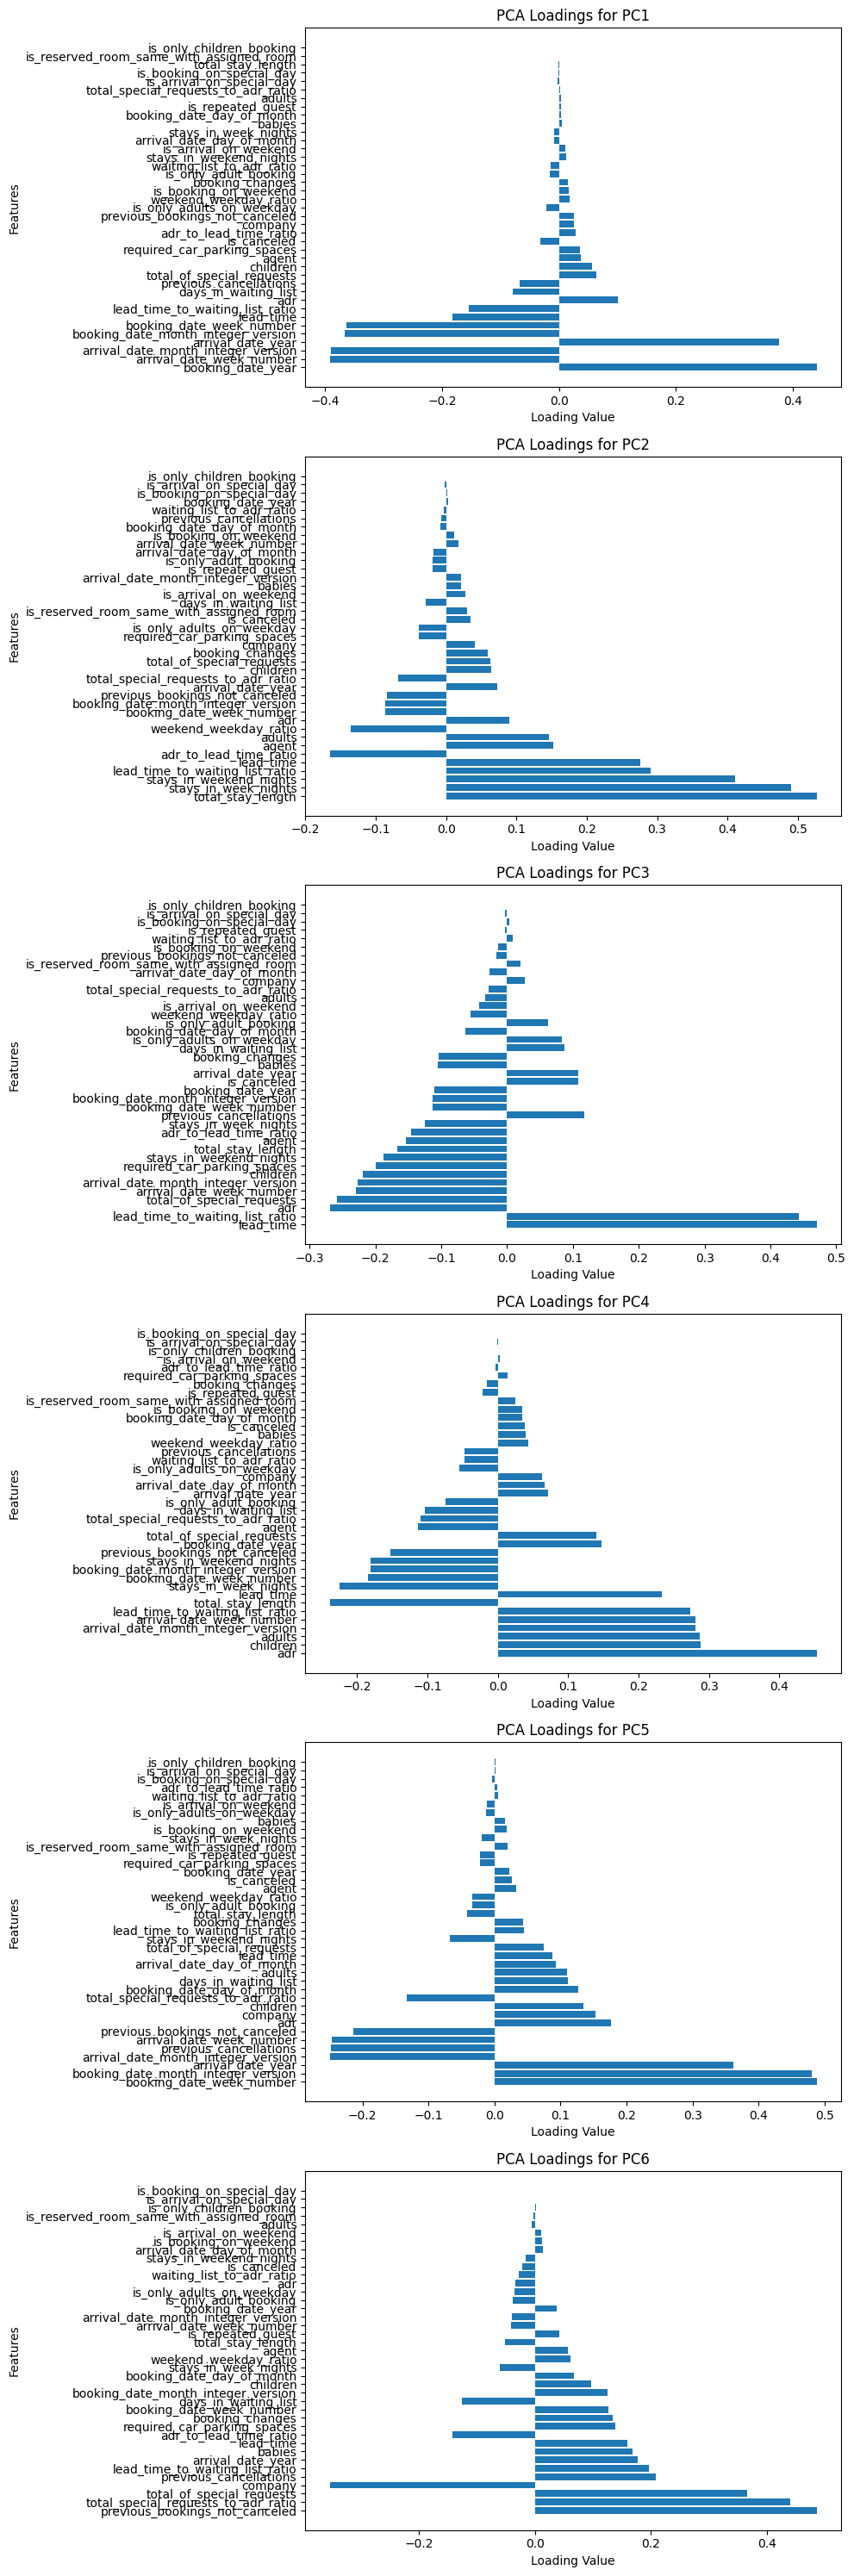

In [21]:
df = pd.read_csv('feature_engineered_data.csv')
result = most_relevant_features_via_pca(df, n_components=6, top_n_features=3)
print("Explained Variance Ratio:", result['explained_variance_ratio'])
print("Top Features per Component:", result['top_features'])
for pc, loadings in result['loadings'].items():
    sorted_loadings = sorted(loadings.items(), key=lambda x: abs(x[1]), reverse=True)
    print(f"Sorted Loadings for {pc}:", sorted_loadings)
def plot_pca_loadings(loadings):
    num_components = len(loadings)
    fig, axes = plt.subplots(num_components, 1, figsize=(10, 5 * num_components))
    
    if num_components == 1:
        axes = [axes]  

    for i, (pc, comp_loadings) in enumerate(loadings.items()):
        sorted_loadings = sorted(comp_loadings.items(), key=lambda x: abs(x[1]), reverse=True)
        features, values = zip(*sorted_loadings)

        axes[i].barh(features, values)
        axes[i].set_title(f'PCA Loadings for {pc}')
        axes[i].set_xlabel('Loading Value')
        axes[i].set_ylabel('Features')

    plt.tight_layout()
    plt.show()
plot_pca_loadings(result['loadings'])

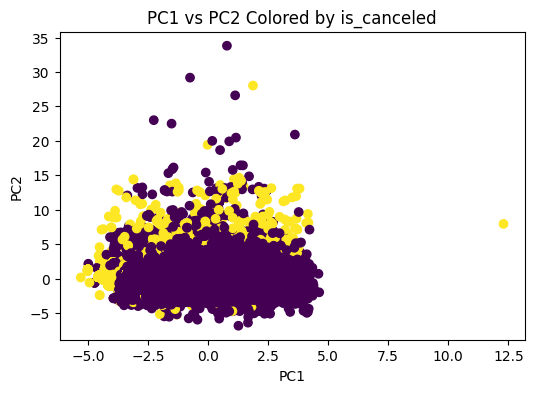

In [22]:
df = pd.read_csv('feature_engineered_data.csv')
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['is_canceled'])
pca = PCA(n_components=2)
scores = pca.fit_transform(numeric_df.values)

# Scatter plot PC1 vs PC2 colored by is_canceled
plt.figure(figsize=(6, 4))
plt.scatter(scores[:, 0], scores[:, 1], c=df['is_canceled'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2 Colored by is_canceled')
plt.show()

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

def mixed_correlation_matrix(
    df: pd.DataFrame,
    dropna: bool = True
) -> pd.DataFrame:

    data = df.copy()
    var_type = {}
    for col in data.columns:
        if pd.api.types.is_numeric_dtype(data[col]):
            uniq = data[col].dropna().unique()
            if len(uniq) == 2:
                var_type[col] = 'binary'
            else:
                var_type[col] = 'continuous'
        else:
            var_type[col] = 'categorical'
            # convert to integer codes
            data[col] = data[col].astype('category').cat.codes

    # 2) Prepare empty matrix
    cols = data.columns
    corr_mat = pd.DataFrame(
        np.eye(len(cols)),
        index=cols, columns=cols,
        dtype=float
    )

    # 3) Compute pairwise correlations
    for i, col_i in enumerate(cols):
        for j, col_j in enumerate(cols):
            if j <= i:
                continue  # skip duplicates & diagonal
            x = data[col_i]
            y = data[col_j]
            # optionally drop NaNs
            if dropna:
                valid = x.notna() & y.notna()
                x_, y_ = x[valid], y[valid]
            else:
                x_, y_ = x, y

            ti, tj = var_type[col_i], var_type[col_j]
            # choose method
            if ti == 'continuous' and tj == 'continuous':
                r = x_.corr(y_, method='pearson')
            elif (ti == 'binary' and tj == 'continuous') or (ti == 'continuous' and tj == 'binary'):
                # ensure binary is first for pointbiserialr
                if ti == 'binary':
                    r = pointbiserialr(x_, y_).correlation
                else:
                    r = pointbiserialr(y_, x_).correlation
            else:
                # binary–binary or any involving categorical codes:
                r = x_.corr(y_, method='pearson')

            corr_mat.at[col_i, col_j] = r
            corr_mat.at[col_j, col_i] = r

    return corr_mat


df = pd.read_csv('feature_engineered_data.csv')
corr = mixed_correlation_matrix(df)
print(corr)


                                             hotel  is_canceled  lead_time  \
hotel                                     1.000000    -0.137082  -0.075970   
is_canceled                              -0.137082     1.000000   0.292876   
lead_time                                -0.075970     0.292876   1.000000   
arrival_date_year                        -0.035176     0.016622   0.040334   
arrival_date_month                       -0.035453    -0.001269   0.086345   
arrival_date_week_number                 -0.001241     0.008315   0.127046   
arrival_date_day_of_month                 0.001678    -0.005948   0.002306   
stays_in_weekend_nights                   0.187816    -0.001323   0.085985   
stays_in_week_nights                      0.235955     0.025542   0.166892   
adults                                    0.010571     0.058182   0.117575   
children                                  0.044013     0.004851  -0.037878   
babies                                    0.043386    -0.032569 

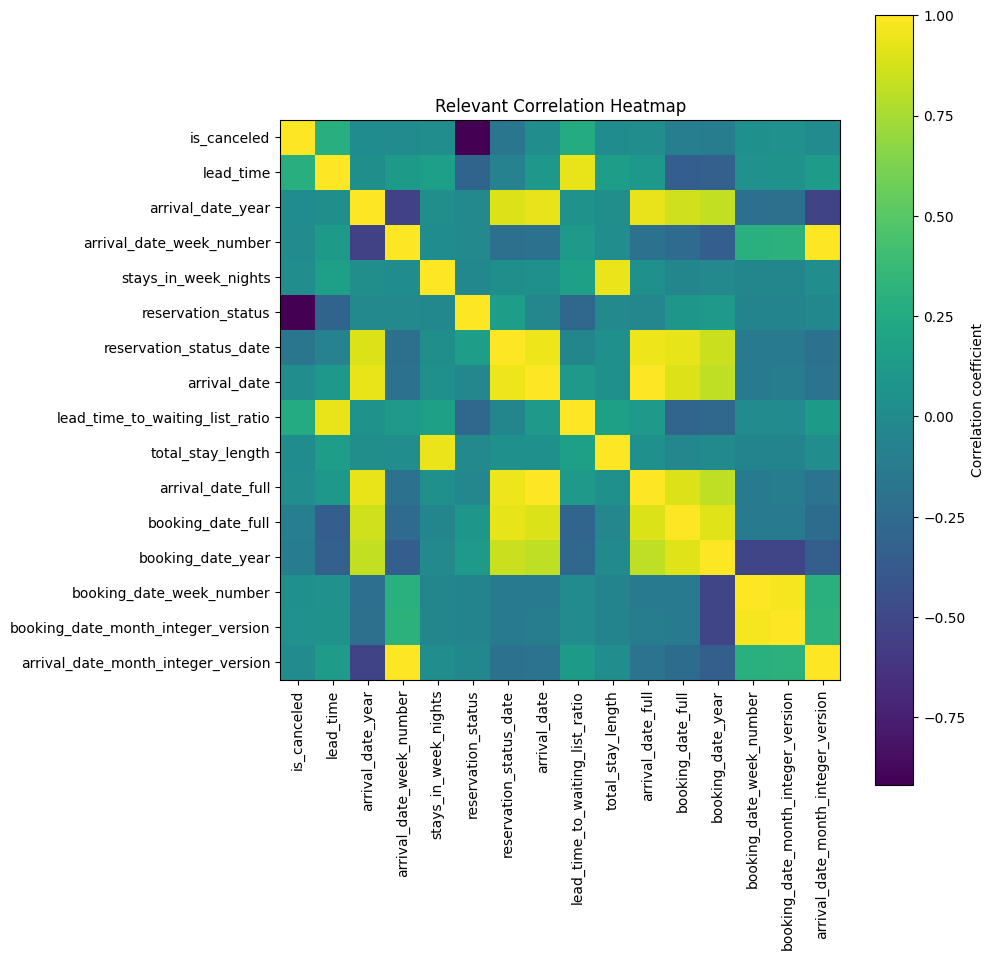

Highly correlated pairs:
reservation_status and is_canceled: -0.9171764065161951
arrival_date and arrival_date_year: 0.9336223369650138
arrival_date and reservation_status_date: 0.9544078084122471
lead_time_to_waiting_list_ratio and lead_time: 0.9390425073011972
total_stay_length and stays_in_week_nights: 0.9402428567744225
arrival_date_full and arrival_date_year: 0.9336223369650138
arrival_date_full and reservation_status_date: 0.9544078084122471
arrival_date_full and arrival_date: 1.0
booking_date_full and reservation_status_date: 0.9298543446584625
booking_date_year and booking_date_full: 0.9100405845219445
booking_date_month_integer_version and booking_date_week_number: 0.9742799631007756
arrival_date_month_integer_version and arrival_date_week_number: 0.9951014120529826


In [24]:
import matplotlib.pyplot as plt

def plot_relevant_correlation_heatmap(
    corr_mat: pd.DataFrame,
    min_abs_corr: float = 0.5,
    title: str = "Relevant Correlation Heatmap"
):

    mat = corr_mat.copy()
    mat_no_diag = mat.mask(pd.DataFrame(np.eye(len(mat), dtype=bool), index=mat.index, columns=mat.columns))
    relevant = mat_no_diag.abs().ge(min_abs_corr).any(axis=1)
    filtered = mat.loc[relevant, relevant]

    if filtered.empty:
        raise ValueError(f"No variables have abs(corr) >= {min_abs_corr}. Lower the threshold.")
    plt.figure(figsize=(len(filtered) * 0.5 + 2, len(filtered) * 0.5 + 2))
    plt.imshow(filtered.values, aspect='equal')
    plt.colorbar(label='Correlation coefficient')
    plt.xticks(range(len(filtered)), filtered.columns, rotation=90)
    plt.yticks(range(len(filtered)), filtered.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()
plot_relevant_correlation_heatmap(corr, min_abs_corr=0.9)
def get_highly_correlated_pairs(corr, threshold=0.9):
    pairs = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
    return pairs
highly_correlated_pairs = get_highly_correlated_pairs(corr, threshold=0.9)
print("Highly correlated pairs:")
for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")


In [25]:

def get_highly_correlated_features(corr_mat: pd.DataFrame, target_col: str, threshold: float = 0.4) -> list:

    # Get absolute correlations with the target column
    abs_corr = corr_mat[target_col].abs()
    
    # Filter features based on the threshold
    highly_correlated_features = abs_corr[abs_corr >= threshold].index.tolist()
    
    # Remove the target column itself from the list
    highly_correlated_features.remove(target_col)
    
    return highly_correlated_features
highly_correlated_features = get_highly_correlated_features(corr, 'is_canceled', threshold=0.1)
print("Highly correlated features with 'is_canceled':", highly_correlated_features)

Highly correlated features with 'is_canceled': ['hotel', 'lead_time', 'country', 'distribution_channel', 'previous_cancellations', 'assigned_room_type', 'booking_changes', 'deposit_type', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'is_reserved_room_same_with_assigned_room', 'lead_time_to_waiting_list_ratio', 'adr_to_lead_time_ratio', 'booking_date_full', 'booking_date_year']


In [26]:
df = pd.read_csv('feature_engineered_data.csv')
data = df.copy()
var_type = {}
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        uniq = data[col].dropna().unique()
        if len(uniq) == 2:
            var_type[col] = 'binary'
        else:
            var_type[col] = 'continuous'
    else:
        var_type[col] = 'categorical'
         # convert to integer codes
        data[col] = data[col].astype('category').cat.codes
ds.scale(data)
df = data.copy()
X = df.drop(columns=['is_canceled']).drop(columns=['reservation_status']).drop(columns=['reservation_status_date'])
y = df['is_canceled']
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_date_week_number,booking_date_day_of_month,booking_season,arrival_season,booking_date_month_integer_version,arrival_date_month_integer_version,is_booking_on_special_day,is_arrival_on_special_day,is_arrival_on_weekend,is_booking_on_weekend
0,1,0,2.225879,-1.63463,-0.138776,-0.012012,-1.685305,-0.931606,-1.317378,0.244780,...,0.320845,1.038849,0.330959,0.557697,0.249156,0.144977,0,0,0,0
1,1,0,5.921785,-1.63463,-0.138776,-0.012012,-1.685305,-0.931606,-1.317378,0.244780,...,0.075466,1.038849,0.330959,0.557697,-0.020609,0.144977,0,0,0,0
2,1,0,-0.908624,-1.63463,-0.138776,-0.012012,-1.685305,-0.931606,-0.790257,-1.493796,...,0.075466,1.038849,0.330959,0.557697,-0.020609,0.144977,0,0,0,0
3,1,0,-0.852484,-1.63463,-0.138776,-0.012012,-1.685305,-0.931606,-0.790257,-1.493796,...,0.014121,0.345584,0.330959,0.557697,-0.020609,0.144977,0,0,0,0
4,1,0,-0.843127,-1.63463,-0.138776,-0.012012,-1.685305,-0.931606,-0.263136,0.244780,...,0.014121,0.230040,0.330959,0.557697,-0.020609,0.144977,0,0,0,0


In [27]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# X is your scaled features, y is your target (is_canceled)
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# Grab importances and pair with column names
importances = pd.Series(rf.feature_importances_, index=X.columns)

# Sort descending
importances = importances.sort_values(ascending=False)

# View the top 20 most important
print(importances.head(25))

deposit_type                                0.101064
country                                     0.095124
lead_time                                   0.063873
total_of_special_requests                   0.055147
lead_time_to_waiting_list_ratio             0.050594
agent                                       0.043191
adr                                         0.040801
booking_date_full                           0.039702
market_segment                              0.039560
arrival_date                                0.031333
arrival_date_full                           0.031222
previous_cancellations                      0.027911
is_reserved_room_same_with_assigned_room    0.026521
booking_date_day_of_month                   0.025964
arrival_date_day_of_month                   0.023374
booking_date_week_number                    0.021224
customer_type                               0.020615
required_car_parking_spaces                 0.019630
total_stay_length                           0.

In [28]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='saga', C=1.0, random_state=42, max_iter=100)
log.fit(X, y)
log_imp = pd.Series(np.abs(log.coef_[0]), index=X.columns).sort_values(ascending=False)
print("Logistic Regression feature importance (abs coef):")
print(log_imp.head(20), "\n")


Logistic Regression feature importance (abs coef):
previous_cancellations                      1.982722
required_car_parking_spaces                 1.789953
is_reserved_room_same_with_assigned_room    1.513421
deposit_type                                1.305599
market_segment                              0.799653
previous_bookings_not_canceled              0.606946
total_of_special_requests                   0.541995
country                                     0.533033
is_repeated_guest                           0.525043
is_only_adult_booking                       0.431802
distribution_channel                        0.355779
adr_to_lead_time_ratio                      0.278662
is_only_children_booking                    0.251323
booking_changes                             0.240560
assigned_room_type                          0.218800
is_only_adults_on_weekday                   0.208630
adr                                         0.194180
is_arrival_on_special_day                   0.19

/Users/nickblazek/miniconda3/envs/finfun/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb.fit(X, y)
gb_imp = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Gradient Boosting feature importances:")
print(gb_imp.head(20), "\n")

Gradient Boosting feature importances:
deposit_type                                0.387160
country                                     0.116825
market_segment                              0.081920
total_of_special_requests                   0.068837
lead_time                                   0.058327
is_reserved_room_same_with_assigned_room    0.051205
agent                                       0.041744
previous_cancellations                      0.037231
required_car_parking_spaces                 0.036266
lead_time_to_waiting_list_ratio             0.028358
booking_changes                             0.018952
customer_type                               0.015477
previous_bookings_not_canceled              0.012450
booking_date_full                           0.011579
arrival_date_full                           0.007367
arrival_date                                0.006909
adr                                         0.004762
booking_date_week_number                    0.002853
total_s

In [30]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k = 20
selector = SelectKBest(mutual_info_classif, k=k)
X_new = selector.fit_transform(X, y)

print("Kept features:", X.columns[selector.get_support()])

# test KNN performance
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_new, y, cv=5, scoring='accuracy')
print(f"KNN accuracy w/ top {k} mutual-info features:", scores.mean())


Kept features: Index(['lead_time', 'country', 'market_segment', 'distribution_channel',
       'previous_cancellations', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'arrival_date', 'is_reserved_room_same_with_assigned_room',
       'lead_time_to_waiting_list_ratio', 'adr_to_lead_time_ratio',
       'arrival_date_full', 'booking_date_full', 'booking_date_year'],
      dtype='object')
KNN accuracy w/ top 20 mutual-info features: 0.5500713027430585


In [31]:
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

def chi2_pval(X, y, feature):
    ct = pd.crosstab(X[feature], y)
    _, p, _, _ = chi2_contingency(ct)
    return p


def ttest_pval(X, y, feature):
    group0 = X.loc[y==0, feature].dropna()
    group1 = X.loc[y==1, feature].dropna()
    _, p = ttest_ind(group0, group1, equal_var=False)
    return p


In [32]:
from scipy.stats import ttest_ind, chi2_contingency
from scipy.stats import ttest_ind, chi2_contingency

def feature_pvalues(X: pd.DataFrame, y: pd.Series, var_type: dict):
    records = []
    for col, kind in var_type.items():
        if kind in ('continuous', 'binary'):
            # two‐sample t-test
            group0 = X.loc[y==0, col].dropna()
            group1 = X.loc[y==1, col].dropna()
            stat, p = ttest_ind(group0, group1, equal_var=False)
            test = 't-test'
        else:
            # chi-square
            ct = pd.crosstab(X[col], y)
            stat, p, _, _ = chi2_contingency(ct)
            test = 'chi2'
        records.append((col, test, p))
    return (
        pd.DataFrame(records, columns=['feature','test','pval'])
          .sort_values('pval')
          .reset_index(drop=True)
    )

def get_var_type(df: pd.DataFrame) -> dict[str,str]:
    var_type = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            uniq = df[col].dropna().unique()
            var_type[col] = 'binary' if len(uniq) == 2 else 'continuous'
        else:
            var_type[col] = 'categorical'
    return var_type

In [33]:
X  = df.drop(columns=['is_canceled'])
y  = df['is_canceled']
var_type = get_var_type(X)
pvals_df = feature_pvalues(X, y, var_type)
pvals_df = pvals_df.sort_values('pval', ascending=False).reset_index(drop=True)
pvals_df['pval'] = pvals_df['pval'].apply(lambda x: f"{x:.6f}")
print(pvals_df.head(80))

                                     feature    test      pval
0                   is_only_children_booking  t-test  0.855214
1                         arrival_date_month  t-test  0.663035
2                    stays_in_weekend_nights  t-test  0.649425
3                  is_booking_on_special_day  t-test  0.129368
4                                   children  t-test  0.098320
5                  arrival_date_day_of_month  t-test  0.040073
6                  is_arrival_on_special_day  t-test  0.023196
7                             booking_season  t-test  0.018777
8                  waiting_list_to_adr_ratio  t-test  0.018740
9                   arrival_date_week_number  t-test  0.003544
10                     is_arrival_on_weekend  t-test  0.001585
11        arrival_date_month_integer_version  t-test  0.000090
12                 is_only_adults_on_weekday  t-test  0.000008
13                     is_only_adult_booking  t-test  0.000006
14                                   company  t-test  0

/Users/nickblazek/miniconda3/envs/finfun/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
